
## 2. Somehow able to read data in these images and convert it to row and column format, so that the data can be inserted into database:  

To have a full-fledged solution for this part is really difficult task. For that reason, you 
are expected here to make a working solution for only the images mentioned in 
dataset_part2 (contains 2 bar graph plots).  You can have different code that works 
for  different images. 

Make use of existing OCR engines  to extract the information in the given images. 

__Tasks:__
- a) Extract and print  ‘title of graph’ and make bounding boxes around the texts detected in the images and save the resultant images with Bounding boxes.Save images as ’ {image_name}_bboxes.png’ 
- b) Make use of computer vision skills, get individual bars and their values (Hint : contour detection, edge detection etc). Write the individual results into ‘{image_name}.csv’  


__Deliverables:__  
- 4. Complete code or notebook .
- 5. Documentation containing instructions to run your code and a requirements.txt file (You can also make use of Markdown cells if you are using a notebook) 

__Resources for part 2:__
- a) The easiest way to get started is using EasyOCR (https://pypi.org/project/easyocr/) . 
- b) Look at cv2 contour detection, edge detection, corner detection. (Feel free to ask and discuss approaches on the graph2table teams channel)

### Install pytesseract if not already installed

### Add all necessary imports

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import csv
import pytesseract
import pandas as pd

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

## b) Make use of computer vision skills, get individual bars and their values (Hint : contour detection, edge detection etc). Write the individual results into ‘{image_name}.csv’  

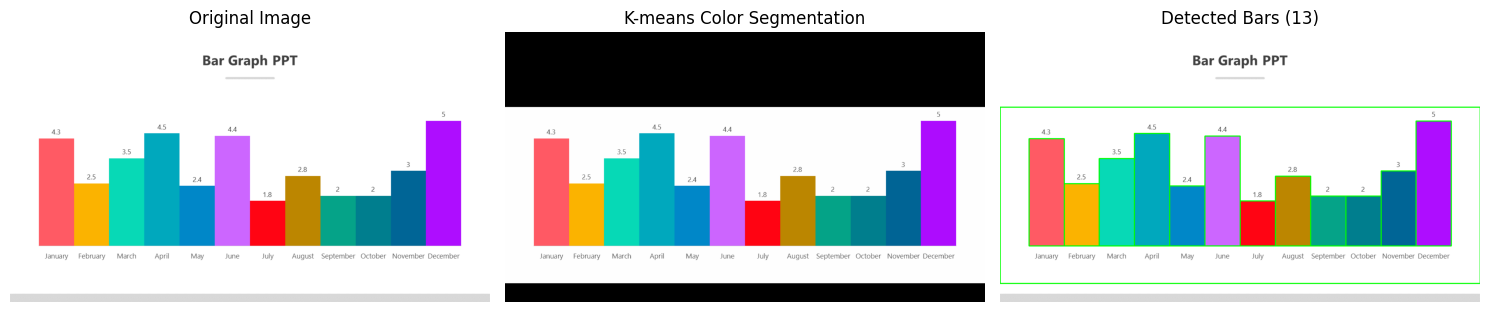

In [10]:
image_path = os.path.join('dataset_part2', 'image_1.png')
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
output_image = image.copy()

# Mask out top 250 and bottom 50 px
height = image_rgb.shape[0]
roi = image_rgb[200:height-50, :, :]  # Keep only the middle section

# Flatten ROI for clustering
pixel_data = roi.reshape((-1, 3))

# K-means clustering on ROI
num_clusters = 15 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(pixel_data)
segmented_roi = kmeans.cluster_centers_.astype("uint8")[labels]
segmented_roi = segmented_roi.reshape(roi.shape)

# Create a blank full-size segmented image
segmented_img = np.zeros_like(image_rgb)
segmented_img[200:height-50] = segmented_roi


# Prepare a blank mask image for each cluster
detected_bars = []

for i in range(num_clusters):
    cluster_mask = (labels == i).reshape(roi.shape[:2]).astype("uint8") * 255
    full_mask = np.zeros(image_rgb.shape[:2], dtype="uint8")
    full_mask[200:height-50] = cluster_mask

    # Optional cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    full_mask = cv2.morphologyEx(full_mask, cv2.MORPH_CLOSE, kernel)

    # Find and draw contours
    contours, _ = cv2.findContours(full_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)

        if area > 200 and w > 10 and h > 20:
            detected_bars.append((x, y, w, h))
            cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(segmented_img)
plt.title("K-means Color Segmentation")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Bars ({len(detected_bars)})')
plt.axis('off')

plt.tight_layout()
plt.show()


### Now check all the detected bars

In [11]:
# Exclude the biggest detected bar
detected_bars_data = []
max_area = max(detected_bars, key=lambda bar: bar[2] * bar[3])  # Find the bar with the largest area

for (x, y, w, h) in detected_bars:
    if (x, y, w, h) != max_area:  # Exclude the largest bar
        detected_bars_data.append({
            'x': x,
            'y': y,
            'width': w,
            'height': h
        })

# Sort detected bars data by x-axis
detected_bars_data_sorted = sorted(detected_bars_data, key=lambda bar: bar['x'])

print("Detected bars data sorted by x-axis:")
for bar in detected_bars_data_sorted:
    print(bar)

Detected bars data sorted by x-axis:
{'x': 77, 'y': 284, 'width': 94, 'height': 286}
{'x': 171, 'y': 404, 'width': 93, 'height': 166}
{'x': 264, 'y': 337, 'width': 94, 'height': 233}
{'x': 358, 'y': 270, 'width': 94, 'height': 300}
{'x': 452, 'y': 410, 'width': 94, 'height': 160}
{'x': 546, 'y': 277, 'width': 94, 'height': 293}
{'x': 640, 'y': 450, 'width': 94, 'height': 120}
{'x': 734, 'y': 384, 'width': 94, 'height': 186}
{'x': 828, 'y': 437, 'width': 94, 'height': 133}
{'x': 922, 'y': 437, 'width': 94, 'height': 133}
{'x': 1016, 'y': 370, 'width': 93, 'height': 200}
{'x': 1109, 'y': 237, 'width': 94, 'height': 333}


### Find different ways to extract values

In [12]:
# Load the image again for OCR
image_path = os.path.join('dataset_part2', 'image_1.png')
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply slight thresholding to clean background
_, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)

bar_value_mapping = {}

for bar_data in detected_bars_data_sorted:
    x, y, w, h = bar_data['x'], bar_data['y'], bar_data['width'], bar_data['height']
    
    # Define ROI above the bar
    roi_y_start = max(0, y - 60)
    roi_y_end = y - 5
    roi = thresh[roi_y_start:roi_y_end, x:x + w]

    # Enlarge ROI to help OCR
    roi = cv2.resize(roi, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

    # Run OCR just on digits
    config = "--psm 7 -c tessedit_char_whitelist=0123456789."
    detected_text = pytesseract.image_to_string(roi, config=config).strip()

    # Add a decimal point if two numbers are detected in a row
    if len(detected_text) == 2 and detected_text.isdigit():
        detected_text = f"{detected_text[0]}.{detected_text[1]}"

    bar_value_mapping[(x, y, w, h)] = detected_text

# Output
bar_values = []
for bar, value in bar_value_mapping.items():
    print(f"Bar at {bar} has value: '{value}'")
    bar_values.append(value)

print("Bar values list:", bar_values)


Bar at (77, 284, 94, 286) has value: '4.3'
Bar at (171, 404, 93, 166) has value: '2.5'
Bar at (264, 337, 94, 233) has value: '3.5'
Bar at (358, 270, 94, 300) has value: '4.5'
Bar at (452, 410, 94, 160) has value: '2.4'
Bar at (546, 277, 94, 293) has value: '4.4'
Bar at (640, 450, 94, 120) has value: '1.8'
Bar at (734, 384, 94, 186) has value: '2.8'
Bar at (828, 437, 94, 133) has value: '2'
Bar at (922, 437, 94, 133) has value: '2'
Bar at (1016, 370, 93, 200) has value: '3'
Bar at (1109, 237, 94, 333) has value: '5'
Bar values list: ['4.3', '2.5', '3.5', '4.5', '2.4', '4.4', '1.8', '2.8', '2', '2', '3', '5']


### Had to look into [this](https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/) to change the psm to make sure it worked!

### Now find a way to detect the text under the bars


In [13]:
# Dictionary to store bar coordinates and detected text
bar_text_mapping = {}

for bar in detected_bars_data_sorted:
    x, y, width, height = bar['x'], bar['y'], bar['width'], bar['height']
    
    # Define ROI below the bar (adjust the height as needed)
    roi_y_start = y + height + 10  # Start 10 pixels below the bar
    roi_y_end = roi_y_start + 50  # Define height of the ROI
    roi = image[roi_y_start:roi_y_end, x:x + width]
    
    # Perform OCR on the ROI
    detected_text = pytesseract.image_to_string(roi, config='--psm 6').strip()
    
    # Map the detected text to the bar
    bar_text_mapping[(x, y, width, height)] = detected_text

# Print the mapping of bars to detected text
for bar, text in bar_text_mapping.items():
    print(f"Bar at {bar} has text: '{text}'")
    


Bar at (77, 284, 94, 286) has text: 'January'
Bar at (171, 404, 93, 166) has text: 'February'
Bar at (264, 337, 94, 233) has text: 'March'
Bar at (358, 270, 94, 300) has text: 'April'
Bar at (452, 410, 94, 160) has text: 'May'
Bar at (546, 277, 94, 293) has text: 'June'
Bar at (640, 450, 94, 120) has text: 'July'
Bar at (734, 384, 94, 186) has text: 'August'
Bar at (828, 437, 94, 133) has text: 'September'
Bar at (922, 437, 94, 133) has text: 'October'
Bar at (1016, 370, 93, 200) has text: 'November'
Bar at (1109, 237, 94, 333) has text: 'December'


### Now combine the code

In [14]:
# Define the output CSV file path
output_csv_path = 'bar_values_image_1_v2.csv'

# Combine bar text and values into rows
rows = [{'Bar Text': bar_text_mapping[(bar['x'], bar['y'], bar['width'], bar['height'])], 'Value': value} for bar, value in zip(detected_bars_data_sorted, bar_values)]

# Write to CSV
with open(output_csv_path, mode='w', newline='') as csv_file:
    fieldnames = ['Bar Text', 'Value']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerows(rows)

print(f"CSV file '{output_csv_path}' created successfully.")

# Print final values in a df
df = pd.DataFrame(rows)
print(df)


CSV file 'bar_values_image_1_v2.csv' created successfully.
     Bar Text Value
0     January   4.3
1    February   2.5
2       March   3.5
3       April   4.5
4         May   2.4
5        June   4.4
6        July   1.8
7      August   2.8
8   September     2
9     October     2
10   November     3
11   December     5


### This is way better because it detects it now instead of using math
